# Python:  Pixel size & dimensions

This section gives a bit of background on working with pixel sizes and dimensions in Python.

It's pretty unsatisfying.
There's a strong chance it will be updated whenever I figure out how to install [AICSImageIO](https://allencellmodeling.github.io/aicsimageio/index.html) on my stubborn computer (and find time to revise the book).

In [1]:
# First, our usual default imports
import sys
sys.path.append('../../../')

from helpers import *
import matplotlib.pyplot as plt
import numpy as np

## Pixel size

Checking the pixel size in Python can be, in my opinion, a bit of a pain.

To see why, let's return to the neuron image used in the 'Channels & colors' chapter.
We can request the metadata when loading it from `imageio`.

In [2]:
# The easy with with the helper function
# im, metadata = load_image('Rat_Hippocampal_Neuron.zip', volume=True, metadata=True)

# The awkward way using imageio directly
import imageio

# Get the path to the image & unzip it (the unzipping isn't needed for .tif images generally)
path = find_image('Rat_Hippocampal_Neuron.zip')[0]
with ZipFile(path, 'r') as zf:
    names = zf.namelist()
    with zf.open(names[0]) as entry:
        image_bytes = entry.read()

# Usually you can just pass the path here, instead of image_bytes
reader = imageio.get_reader(image_bytes, format='.tif')
metadata = reader.get_meta_data()
print(metadata)

{'is_fluoview': False, 'is_nih': False, 'is_micromanager': False, 'is_ome': False, 'is_lsm': False, 'is_reduced': False, 'is_shaped': False, 'is_stk': False, 'is_tiled': False, 'is_mdgel': False, 'compression': 1, 'predictor': 1, 'is_mediacy': False, 'description': 'ImageJ=1.44o\nimages=5\nchannels=5\nmode=color\nunit=um\nloop=false\nmin=472.0\nmax=2436.0', 'description1': '', 'is_imagej': True, 'software': '', 'resolution_unit': 1, 'resolution': (6.25, 6.25, 'NONE')}


Printing that a little more nicely, we get:

In [3]:
for k, v in metadata.items():
    print(f'{k}: {v}')

is_fluoview: False
is_nih: False
is_micromanager: False
is_ome: False
is_lsm: False
is_reduced: False
is_shaped: False
is_stk: False
is_tiled: False
is_mdgel: False
compression: 1
predictor: 1
is_mediacy: False
description: ImageJ=1.44o
images=5
channels=5
mode=color
unit=um
loop=false
min=472.0
max=2436.0
description1: 
is_imagej: True
software: 
resolution_unit: 1
resolution: (6.25, 6.25, 'NONE')


This metadata is actually quite ImageJ-specific, and other TIFFs may give quite different metadata.

We can see the version of ImageJ that wrote the file, but picking out the key thing we want - the pixel size - is not so easy.

Seeing `unit=um` is encouraging, but the most relevant-looking other value we have is `resolution: (6.25, 6.25, 'NONE')`.

It's tempting to suppose that means the pixel width and height are both 6.25 µm - *however* if I check the same image in ImageJ itself, I see the pixel width and height are actually 0.16 µm... which happens to equal 1.0/6.25 µm.

In [4]:
print(1.0 / 6.25)

0.16


Therefore the information **is** in the metadata, but it's very easy to misinterpret - and it isn't even guaranteed to be correct if the image was written by some other software.

I'd like to give you a solution to this problem, but at the time of writing I don't have a good one.

My best idea is to check out [**AICSImageIO**](https://github.com/AllenCellModeling/aicsimageio) - which is a really interesting-looking Python library that standardized reading and writing multiple file formats.

Alas, I have the misfortunate to be unable to install it right now because I'm currently using an Apple Silicon Mac and my attempts have been thwarted by mysterious errors.
So I can't say a great deal more about it for now.

## Dimensions

I have a strong suspicion that **AICSImageIO** might also be the key to working effectively with multidimensional images.
But for now, we'll persist with `imageio`.

In [5]:
im, metadata = load_image('confocal-series.zip', volume=True, metadata=True)
print(f'Shape: {im.shape}')

print('Metadata:')
for k, v in metadata.items():
    print(f'{k}: {v}')

Shape: (25, 2, 400, 400)
Metadata:
is_fluoview: False
is_nih: False
is_micromanager: False
is_ome: False
is_lsm: False
is_reduced: False
is_shaped: False
is_stk: False
is_tiled: False
is_mdgel: False
compression: 1
predictor: 1
is_mediacy: False
description: ImageJ=1.51h
images=50
channels=2
slices=25
hyperstack=true
mode=composite
unit=\u00B5m
spacing=0.6
loop=false
min=0.0
max=230.0
description1: 
is_imagej: True
software: 
resolution_unit: 1
resolution: (18.363786, 18.363786, 'NONE')


In this case, I've read a z-stack with 25 slices and 2 channels.
I can find that information buried in the metadata, which helps make sense of the curious shape: the order of the dimensions seems to be ZCYX.

Since we already considered how to view multichannel images in the last chapter, let's extract a single channel here.

In [6]:
# Channels come second
# This gives us all the z-slices (:), the first channel (0), everything else (...)
im_single = im[:, 0, ...]
print(f'New shape: {im_single.shape}')

New shape: (25, 400, 400)


At this point, NumPy becomes quite fun - because it is *so easy* to do stuff along different dimensions.

For example, we can rapidly generate different z-projections.

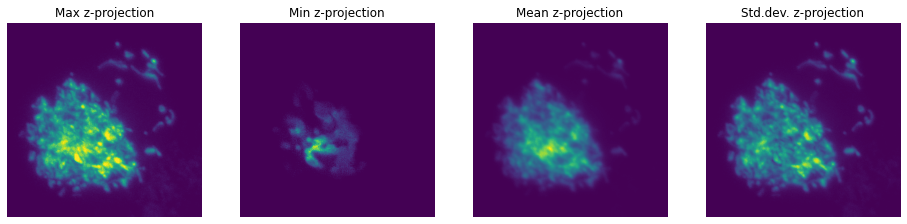

In [7]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(im_single.max(axis=0))
plt.axis(False)
plt.title('Max z-projection')

plt.subplot(1, 4, 2)
plt.imshow(im_single.min(axis=0))
plt.axis(False)
plt.title('Min z-projection')

plt.subplot(1, 4, 3)
plt.imshow(im_single.mean(axis=0))
plt.axis(False)
plt.title('Mean z-projection')

plt.subplot(1, 4, 4)
plt.imshow(im_single.std(axis=0))
plt.axis(False)
plt.title('Std.dev. z-projection')

plt.show()

But we're not limited to projecting along z - we can just switch the `axis` value and project along some other dimension.

> Note that this won't do any correction for differences in pixel size in xy vs. z. With only 25 z-slices, these projections look extremely squashed.

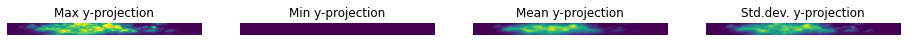

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(im_single.max(axis=1))
plt.axis(False)
plt.title('Max y-projection')

plt.subplot(1, 4, 2)
plt.imshow(im_single.min(axis=1))
plt.axis(False)
plt.title('Min y-projection')

plt.subplot(1, 4, 3)
plt.imshow(im_single.mean(axis=1))
plt.axis(False)
plt.title('Mean y-projection')

plt.subplot(1, 4, 4)
plt.imshow(im_single.std(axis=1))
plt.axis(False)
plt.title('Std.dev. y-projection')

plt.show()

And we can also slice wherever we like as well, to obtain orthogonal views.

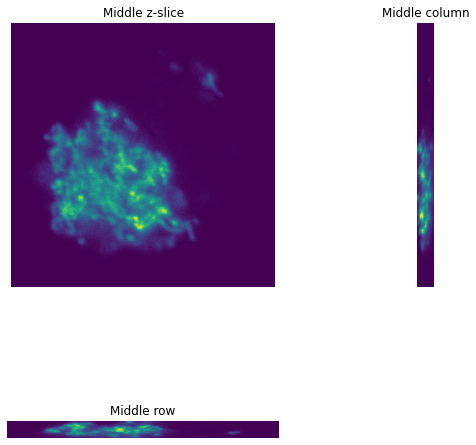

In [9]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(im_single[im_single.shape[0]//2, ...])
plt.axis(False)
plt.title('Middle z-slice')

plt.subplot(2, 2, 3)

plt.imshow(im_single[:, im_single.shape[1]//2, ...])
plt.axis(False)
plt.title('Middle row')

plt.subplot(2, 2, 2)
plt.imshow(im_single[..., im_single.shape[2]//2].transpose())
plt.axis(False)
plt.title('Middle column')

plt.tight_layout()
plt.show()